In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from logistic_regression_utils import remove_all_correlated_features

df = pd.read_csv('./data/zbiór_5.csv')
df = remove_all_correlated_features(df, threshold=0.75)
df

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Wartosci_niematerialne_prawne,Naleznosci_dlugoterminowe,Zapasy,Naleznosci_krotkoterminowe,Naleznosci_dostaw_uslug_12m_powiazane,Naleznosci_dostaw_uslug_pow12m_powiazane,...,wsk_zast_kapitalu_podstawowego,wsk_zast_kapitalu_stalego,wsk_sytuacji_fin,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,4671,2647,0.0,0.00,0.00,6799.49,0.0,0.0,...,500.000000,359.778800,0.002240,5.291262,4.464217,0.508670,0.508670,-0.148422,0.183009,1
1,117,214,2849,2066,0.0,0.00,0.00,0.00,0.0,0.0,...,50.000000,50.000000,0.500000,inf,0.000000,0.000000,0.000000,-1.000000,1.000000,1
2,117,214,7022,3163,0.0,0.00,0.00,0.00,0.0,0.0,...,50.000000,59.375900,0.593759,inf,0.000000,0.000000,0.000000,-1.000000,1.000000,1
3,117,214,6312,1947,0.0,0.00,0.00,111575.06,0.0,0.0,...,8.285974,124.227133,23.770624,0.161707,5.184009,0.613571,0.613571,0.838293,0.154905,1
4,117,214,6201,2586,0.0,0.00,0.00,1961.43,0.0,0.0,...,40.549300,19.614300,0.196143,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,117,215,2453,6296,0.0,0.00,7968.64,746246.30,0.0,0.0,...,9.684433,47.918210,184.392896,3.318065,0.343787,0.000000,0.000000,-0.519891,0.740130,0
2996,117,227,5610,5843,0.0,0.00,20633.09,58250.65,0.0,0.0,...,0.468388,1.867113,0.360100,0.293429,2.407978,0.518839,0.518839,0.706571,-0.521425,0
2997,117,0,6622,1926,0.0,0.00,0.00,2450.00,0.0,0.0,...,100.000000,417.310400,1664.525201,3.019227,0.261454,0.000000,0.000000,-0.530174,0.792260,0
2998,117,0,4110,1510,0.0,0.00,813.01,49045.90,0.0,0.0,...,50.000000,267.990800,0.011605,0.537498,0.861681,0.000000,0.000000,0.462201,0.537149,0


In [34]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['default'])
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.05):
        self.alpha = alpha
        self.lower = alpha
        self.upper = 1-alpha
        assert 0 <= self.lower < self.upper <= 1, "lower < upper and both in [0,1]"

    def fit(self, X, y=None):
        X_ = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.columns_ = X_.columns
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}
        for col in self.columns_:
            self.lower_bounds_[col] = np.nanquantile(X_[col], self.lower)
            self.upper_bounds_[col] = np.nanquantile(X_[col], self.upper)
        return self

    def transform(self, X):
        check_is_fitted(self, ["lower_bounds_", "upper_bounds_", "columns_"])
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            low = self.lower_bounds_[col]
            up = self.upper_bounds_[col]
            X_df[col] = X_df[col].clip(lower=low, upper=up)
        return X_df if isinstance(X, pd.DataFrame) else X_df.to_numpy()


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
# import quantile transformer
from sklearn.preprocessing import QuantileTransformer

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

def replace_inf(X):
    X = X.copy()
    for col in X.select_dtypes(include=[np.number]).columns:
        maximum = X[col].filter(X[col] < np.inf).max()
        X[col] = X[col].replace([np.inf], maximum)
    return X

numerical_pipeline = Pipeline(steps=[
    ('replace_inf', FunctionTransformer(replace_inf)),
    ('imputer', SimpleImputer(strategy='median')),
    ('quantile_clipper', QuantileClipper(alpha=0.05)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga', penalty='elasticnet', l1_ratio=0.5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
                           
pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.96      0.68      0.80       564
           1       0.11      0.61      0.18        36

    accuracy                           0.68       600
   macro avg       0.54      0.65      0.49       600
weighted avg       0.91      0.68      0.76       600



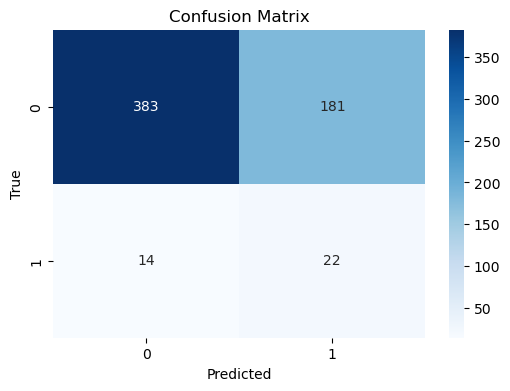

ROC AUC Score: 0.7227


In [15]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# roc_auc score
from sklearn.metrics import roc_auc_score
y_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

In [16]:
# do random search for hyperparameters using RandomizedSearchCV and distributions from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
param_distributions = {
    'classifier__C': loguniform(1e-4, 1e4),
    'classifier__l1_ratio': uniform(0, 1),
    # 'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'preprocessor__num__quantile_clipper__alpha': uniform(0, 0.2)
}

search = RandomizedSearchCV(pipeline, param_distributions, n_iter=100, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1, random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))
print("Best hyperparameters:", search.best_params_)
# auc
y_prob_best = best_model.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, y_prob_best)
print(f"Best ROC AUC Score: {roc_auc_best:.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       564
           1       0.16      0.69      0.26        36

    accuracy                           0.76       600
   macro avg       0.57      0.73      0.55       600
weighted avg       0.93      0.76      0.82       600

Best hyperparameters: {'classifier__C': 0.010333759897666469, 'classifier__l1_ratio': 0.49724850589238545, 'preprocessor__num__quantile_clipper__alpha': 0.06017566196335394}
Best ROC AUC Score: 0.8002


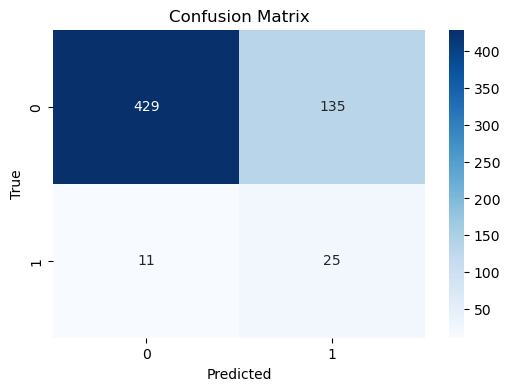

In [17]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# print features with highest coefficients

# Get feature names
feature_names = numerical_features + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Transform to pandas DataFrame
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)

coef = best_model.named_steps['classifier'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef.flatten()})
print("Top 10 features by coefficient magnitude:")
print(coef_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10))

# do the t-test for all features using the preprocessed data
from scipy.stats import ttest_ind

p_values = []
for feature in feature_names:
    stat, p = ttest_ind(X_train_preprocessed_df[feature][y_train == 0], 
                        X_train_preprocessed_df[feature][y_train == 1])
    p_values.append(p)

coef_df['p-value'] = p_values
print("\nTop 10 features by p-value (most statistically significant):")
coef_df.sort_values(by='p-value', ascending=True)


Top 10 features by coefficient magnitude:
                                  Feature  Coefficient
102                        wsk_zadluzenia     0.405597
16                       Srodki_pieniezne    -0.272990
44            koszty_operacyjne_pozostale     0.223254
51       wsk_Zobowiazania_krotkoterminowe    -0.151868
30               Kredyty_pozyczki_krotkie    -0.141945
74   wsk_rotacja_wartosci_niewaterialnych    -0.106906
80    wsk_rotacja_zobowiazan_dostaw_uslug     0.086423
57                     wsk_marza_ebitda_3    -0.066892
69          wsk_ebitda_koszty_finansowe_3    -0.062720
84   wsk_poziom_kapitalu_obrotowego_netto    -0.060396

Top 10 features by p-value (most statistically significant):


,Feature,Coefficient,p-value
102,wsk_zadluzenia,0.405597,1.524006e-14
16,Srodki_pieniezne,-0.272990,3.715393e-05
15,Inwestycje_krotkoterminowe,-0.008607,1.638114e-04
55,wsk_ebitda_2,0.000000,8.191628e-04
85,wsk_udzial_zob_biez_sprzedaz_1,0.005245,1.049109e-03
...,...,...,...
49,RP_przeplywy_operacyjne,0.000000,NaN
54,wsk_akt_generowania_got_2,0.000000,NaN
62,wsk_pokrycie_wyd_fin_gotowkowe_2,0.000000,NaN
64,wsk_zadluzenia_gotowki_2,0.000000,NaN
